# Ireland Met Eireann West Coast Historical Wind Data Analysis <br/> Guillermo F. Martin Gonzalez

# Introduction
This notebooks contains all the analysis carried as part of the project for the 2024 **Programming for Data Analytics (PFDA)** course from the Atlantic Technical University. The project was set up quite open both in terms of the data to be used and the questions to be asked. I have followed the suggestion of downloading the historical wind data from the Met Eireann website (https://www.met.ie/climate/available-data/historical-data). I had never used wind or weather data in the past (I come from a fisheries data background), which meant was something new to me. I have taken the assessment project a step further by downloading the data from three different weather stations in the West Coast of Ireland. **The main purpose of this notebook is to identify which of the three stations would be most suitable to develop a wind farm**. 

# Data 
Three historical weather data `.csv` files were downloaded from the MetEireann website (above) belonging to the stations:

- hly275
- hly2275
- hly2375

The format of these `.csv` files was slightly different in the number of preliminary rows which described the column headers and the units of each column. In each of these files, we manually deleted this columns, and left the header as the first row. This was done to facilitate the loading of the data into Python. The data contained in this `.csv` files is decribed in the `KeyHourly.txt` file, but as a summary: 

- rain:Precipitation Amount (mm)
- temp: Air Temperature (°C)
- wetb: Wet Bulb Air Temperature (°C)
- dewpt: Dew Point Air Temperature (°C)		                 
- vappr: Vapour Pressure (hpa)
- rhum: Relative Humidity (%)
- msl: Mean Sea Level Pressure (hPa)
- wdsp: Mean Hourly Wind Speed (kt)
- wddir: Predominant Hourly wind Direction (deg)
- ww: Synop Code Present Weather - decode in `.txt`
- w: Synop Code Past Weather - decode `.txt`
- sun: Sunshine duration (hours)
- vis: Visibility (m)
- clht: Cloud Ceiling Height - if none value is 999 (100s feet)
- clamt: Cloud Amount (okta)


Additionally, we also downloaded the Station details from this website which contain useful information such as the location of the station or the opening year. 

In [38]:
# Loading libraries
import pandas as pd
import numpy as np 
import os, json 
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import folium as fo
#import plotly.express as px
from windrose import WindroseAxes
import io
import base64
from pygam import LinearGAM, s, f, l
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [39]:
# Loading all .csv files in the data folder
path_to_csv = './data'
csv_files = ['hly2375.csv','hly275.csv','hly2275.csv']

#Station details file: 
stdetails = pd.read_csv(os.path.join(path_to_csv,'StationDetails.csv'))
#Error tokenizing data. C error: Expected 10 fields in line 212, saw 11
# There was a mistake in line 212 in the original .csv file. The name of the station was divided between
# the station name and the height column. I merged them together manually. No height for this station. 
stdetails['height(m)'] = stdetails['height(m)'].astype(float).fillna(0).astype(int)


# Initialize a list to store all data
data_list = []

for index, d in enumerate(csv_files):
    with open(os.path.join(path_to_csv, d)) as csv_file:
        tmp = pd.read_csv(csv_file)
        #tmp['Location'] = d.split('_')[0]
        tmp['StId'] = int(d.split('.')[0].replace('hly', ''))
        data_list.append(tmp) 

data = pd.concat(data_list, ignore_index=True)       

# Merging station details
data = data.merge(stdetails[['station name', 'name', 'latitude', 'longitude']], left_on='StId', right_on='station name', how='left')
data.drop(columns=['station name'], inplace=True)

#Columns of interest to numeric:
dcolumns = ["rain","temp","wetb","dewpt","vappr",'wdsp','rhum','wddir'] # Columns of interest  
#Making sure they all are numeric
data[dcolumns] = data[dcolumns].apply(pd.to_numeric, errors='coerce')

C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\3868201802.py:18: DtypeWarning: Columns (12,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_file)
C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\3868201802.py:18: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_file)
C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\3868201802.py:18: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(csv_file)


In [40]:
# Convert date to datetime.
data['date'] = pd.to_datetime(data['date'],format='%d/%m/%Y %H:%M')
# Name as a category
data['name'] = data['name'].astype('category')

#Extracting season and month for analysis later https://stackoverflow.com/questions/69024042/seasonal-windrose-subplots 
data['year'] = pd.to_datetime(data['date']).dt.year
data['month'] = pd.to_datetime(data['date']).dt.month
data["season"] = data["date"].dt.month%12 //3 +1

season_dict = {1: "winter", 2: "spring", 
               3: "summer", 4: "autumn"}
data["season"] = data["season"].map(season_dict)

# Analysis
## Brief Overview
The following map shows the location of the stations downloaded. If you click on the markers, you will be able to see a windrose plot of all the historical wind speeds and wind directions for each station. A windrose plot is a really nice chart to display the main wind patterns. Wind direction is displayed over 360 degrees using columns or charts. The wind speed or strength is represented by colours within the charts (also referenced in a layer). We have normed the plot, meaning the data is normalized, so the numbers within each plot are percentages, meaning the sum of the different wind direction charts equals to one.  

For instance, in Bellmullet, the most dominant wind direction was from the West (11.6% of the time), followed by S to SW directions (around 9% of the time each). The range of the different colours also indicate the percentage fo the time the wind was blowing at that given range. In the Westerly direction, winds above 21 knots were blowing only around 2% of the time. 

If we make a quick comparison across the three stations, it is clear that the most dominant wind direction in Belmullet and Mace Head is from the West, although S-SW winds are more prevalent in Belmullet. Valentia shows a much more distinctive pattern, with dominant winds clearly blowing from the South (around 14% of the time), and winds above 21 knots being less common than in the stations to the North.


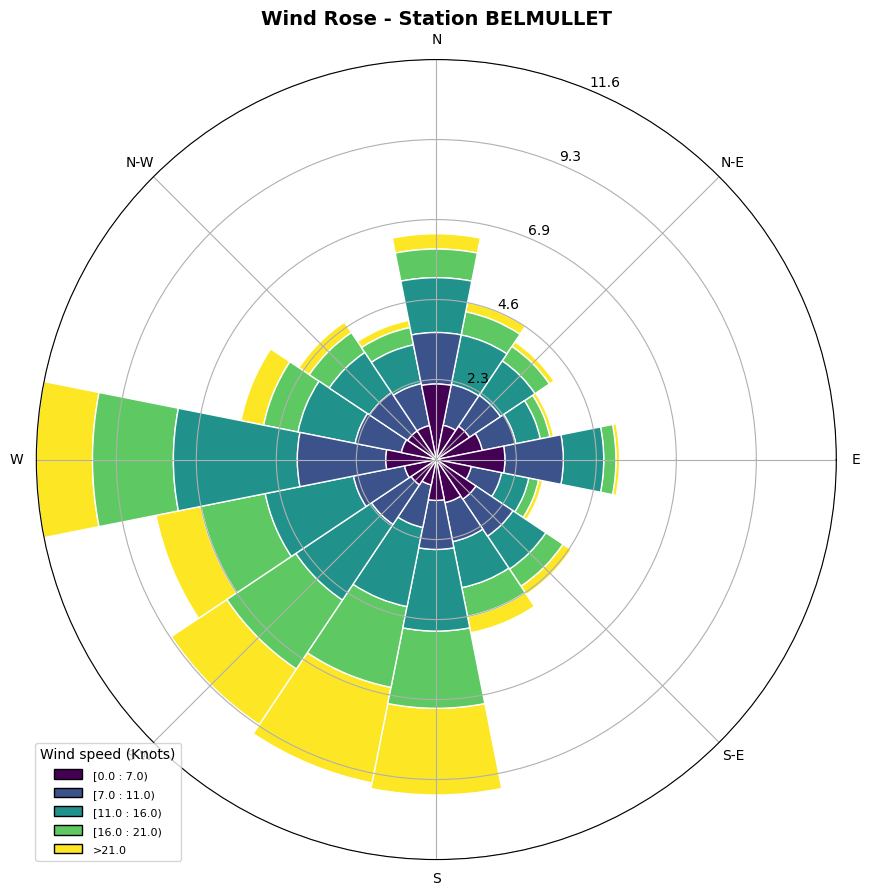
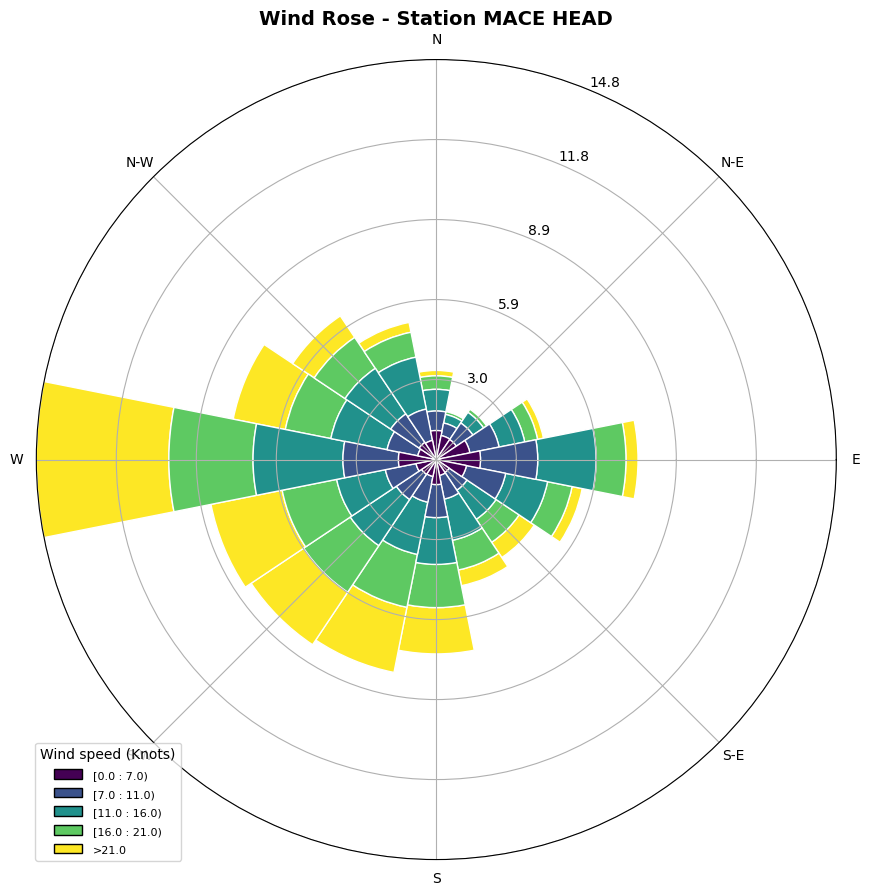
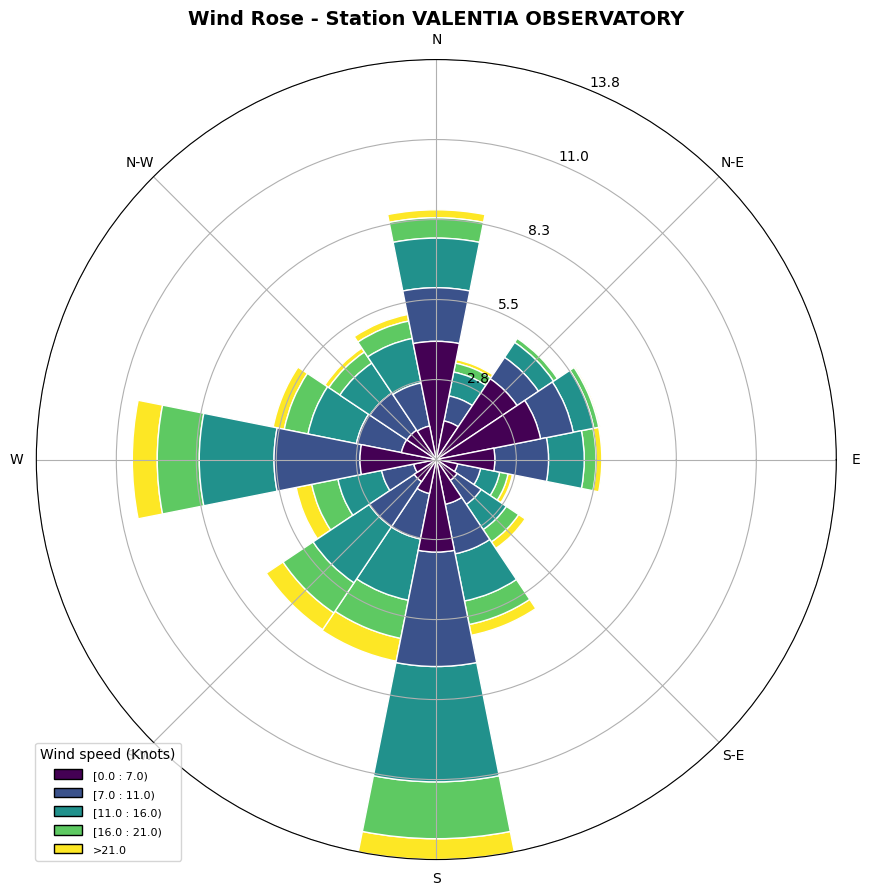

In [41]:
# Function to create a wind rose and return as a base64-encoded string

# Bins for the windrose colour breaks: 
bins= np.append(0, data['wdsp'].quantile([0.25, 0.5, 0.75, 0.9]).values) #Color breaks of windspeed based on speed quantiles

def make_windrose(ws, wd, station_id):
    fig = plt.figure(figsize=(10, 10))
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(wd, ws, normed=True, opening=1, edgecolor='white',bins=bins)
    ax.set_legend(title="Wind speed (Knots)", loc='lower left')
    plt.title(f"Wind Rose - Station {station_id}",fontsize=14, weight='bold')
    
    # Save the plot to a BytesIO buffer
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", transparent=True)
    buf.seek(0)
    base64_img = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return f"data:image/png;base64,{base64_img}"

# Create a folium map
m = fo.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=6)

# Add wind roses to the map
for station_name in data['name'].unique():
    tmp = data[data['name'] == station_name]
    station_id = station_name
    lat = tmp['latitude'].iloc[0]
    lon = tmp['longitude'].iloc[0]

    # Generate wind rose as a base64-encoded image
    windrose_img = make_windrose(tmp['wdsp'], tmp['wddir'], station_id)
    
    # Add the image to the map as an HTML popup
    popup_html = f'<img src="{windrose_img}" style="width: 300px; height: 300px;">'
    popup = fo.Popup(popup_html, max_width=300)
    fo.Marker([lat, lon], popup=popup, tooltip=f"Station {station_id}").add_to(m)
    
    #To be directly displayed on the map withouth the need of a popup
    #html = f"""
    #<div style="width:200px; height:200px; background-color:white; border:1px solid black; border-radius:5px;">
    #    <img src="{windrose_img}" style="width:200px; height:200px; object-fit:contain;">
    #</div>
    #"""
    #icon = fo.DivIcon(html=html)
    #fo.Marker([lat, lon], icon=icon).add_to(m)
# Display the map
m

## Data exploration
Although the windroses help to visually understand the differences in wind direction and speed over the three different areas, we will explore and try to quantify better where these differences arise. We will first explore the trends in annual and monthly wind speeds, to understand if there is any temporal trends and differences across stations. 

We expect the wind speed and direction to change over time. An easy approach to assess differences in wind speed over time and across the three stations is using a boxplot. We can see that Mace Head wind speeds are slightly higher than the other two stations. There is a very clear seasonal pattern with wind speeds peaking in the winter months, and then decreasing over spring and summer. 

In [42]:
# Setting the TimeStamp as the index for calculations: 
data.set_index('date', inplace=True)
wdsp_month_mean = data.groupby('name')['wdsp'].resample('M').mean().reset_index()
wdsp_year_mean = data.groupby('name')['wdsp'].resample('Y').mean().reset_index()

C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\3726199873.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wdsp_month_mean = data.groupby('name')['wdsp'].resample('M').mean().reset_index()
C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\3726199873.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  wdsp_month_mean = data.groupby('name')['wdsp'].resample('M').mean().reset_index()
C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\3726199873.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wdsp_year_mean = data.groupby('name')['wdsp'].resample('Y'

THe first thing to notice is the different in the timeframe of data reported across the three stations. Mace Head only has data reported since August 2003, whereas the other two stations expand much further in time. We have subset the data since 2004 as wel, as to provide a plot with the same timeframe. There is an obvious drop in the wind speeds in both Belmullet and Valentia in the early 2000's. There is also a time pattern across the three stations with spikes in wind speeds every 5-6 years. Monthly wind speeds means also display a within-year seasonal pattern, with stronger wind speeds in the winter months (darker gray background). Both in the annual and monthly plots, it is clear that the station with the stronger winds is Mace Head, followed by Belmullet and Valentia. 

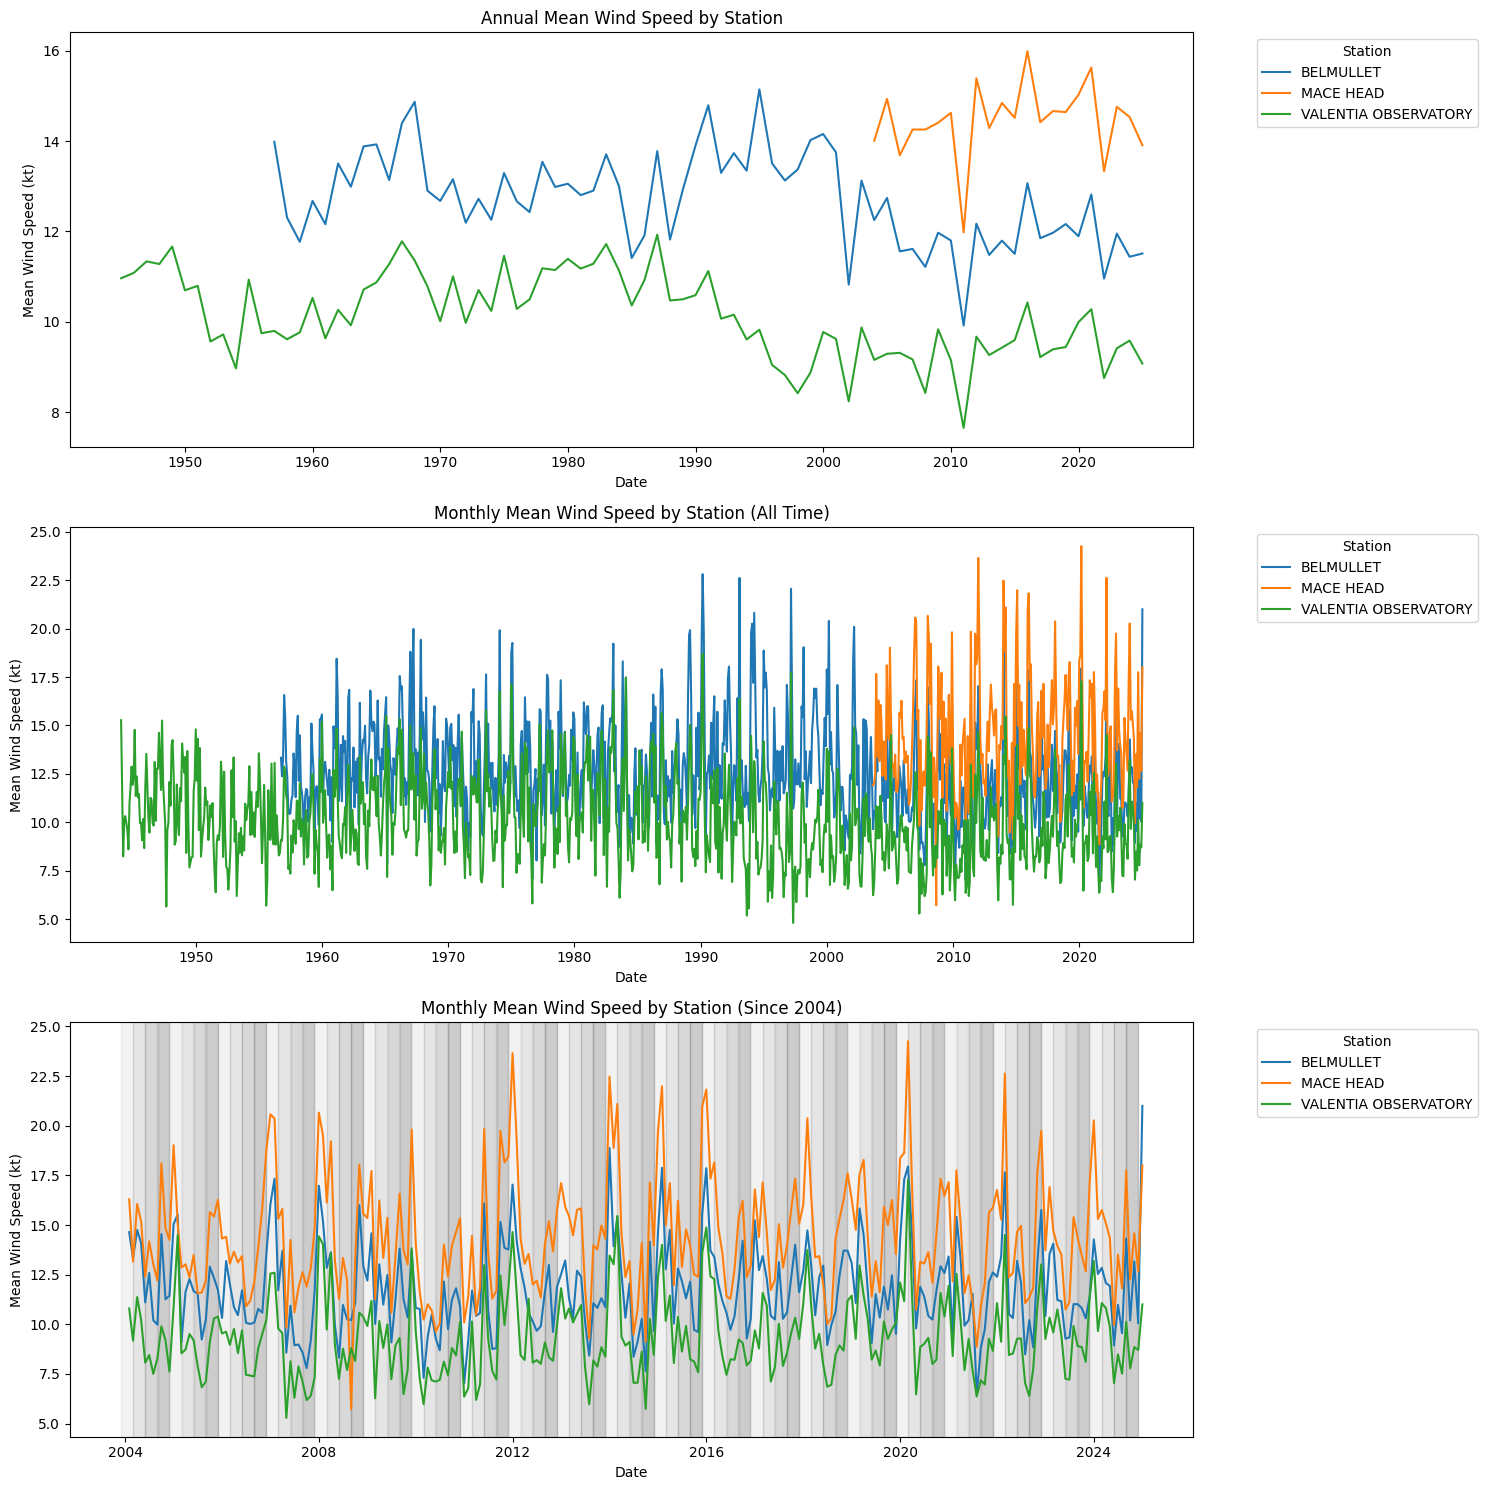

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

sns.lineplot(ax=axes[0],x='date', y='wdsp', hue='name', data=wdsp_year_mean)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Mean Wind Speed (kt)')
axes[0].set_title('Annual Mean Wind Speed by Station')
axes[0].legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')

wdsp_month_mean_2004 = wdsp_month_mean[wdsp_month_mean['date'] >= '2004-01-01']

# Plot all time series
sns.lineplot(ax=axes[1], x='date', y='wdsp', hue='name', data=wdsp_month_mean)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Mean Wind Speed (kt)')
axes[1].set_title('Monthly Mean Wind Speed by Station (All Time)')
axes[1].legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot time series since 2003
# Define background color for seasons
def add_season_background(ax):
    for year in range(wdsp_month_mean_2004['date'].dt.year.min(), wdsp_month_mean_2004['date'].dt.year.max() + 1):
        for season, (start_month, end_month), alpha in zip(['Winter', 'Spring', 'Summer', 'Autumn'], [(12, 2), (3, 5), (6, 8), (9, 11)], [0.1, 0.2, 0.3, 0.4]):
            if start_month > end_month:  # Winter case
                start_date = pd.Timestamp(year=year-1, month=start_month, day=1)
                end_date = pd.Timestamp(year=year, month=end_month, day=28)
            else:
                start_date = pd.Timestamp(year=year, month=start_month, day=1)
                end_date = pd.Timestamp(year=year, month=end_month, day=28)
            ax.axvspan(start_date, end_date, color='gray', alpha=alpha)

sns.lineplot(ax=axes[2], x='date', y='wdsp', hue='name', data=wdsp_month_mean_2004)
add_season_background(axes[2])
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Mean Wind Speed (kt)')
axes[2].set_title('Monthly Mean Wind Speed by Station (Since 2004)')
axes[2].legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Considering the differences in timeframe across stations, we will subset the raw data from 2004 onwards only. Unbalanced data requires careful attention if investigated within statistical frameworks. Subsetting from 2004 onwards still provides 10 years of data, which is still consider a long time series for analysis. 

In [44]:
datasub = data[data.index >= '2004-01-01']

## First question
After this brief exploration, the first question is worth asking, is: is there any significant differences in wind speeds across the three stations of data over the years, and which stations shows the largest wind speeds? 

Generalized Additive Models, also known as GAM's (https://pygam.readthedocs.io/en/latest/index.html), are extensions of the linear modelling framework that allow for the inclusion of different distribution families (not just normal), but also, include the option of adding non-linear effect to covariates. Answering the question of which of the three stations has the strongest wind speeds, could be simply tackled by setting up a linear model with the form ```Windspeed ~ StationName```. However, we saw in the previous section that there is a very clear within year non-linear pattern, with wind speeds stronger in the winter and Autumn months. We can use the flexibility of GAM's to model this pattern while also answering the question of which station has the strongest wind speeds. 

We have therefore set up a GAM model with the following covariates: 

- Cyclic smooth term (spline) to assess if there is any pattern in wind speeds depending on the time of the data. We have set this spline to be Cyclic, as seasonality within a year is a cyclic event. 
- Fixed term effect for Station, to serve as an intercept to assess the difference in wind speeds across the stations 
- Linear term for year, to assess if there is any trend in wind speeds across the time series. 

We have implemented a nested model approach, with 4 different GAMS's, where we have removed one covariate at a time, in order to contrast which covariates are meaningful, and which can be removed.

In [45]:
# First we select the variables of interest to include in our GAM model
datasub_gam = datasub.reset_index()[['date', 'wdsp','year', 'name']]

# Convert date to ordinal for the GAM model
datasub_gam['day_of_year'] = datasub_gam['date'].dt.dayofyear
# Extract hour of the day (an extra model)
#datasub_gam['hour_of_day'] = datasub_gam['date'].dt.hour

# Drop rows with NaN values in 'wdsp'
datasub_gam = datasub_gam.dropna(subset=['wdsp'])

In [46]:
# Define the GAM model
gam = LinearGAM(s(0, n_splines=10, basis='cp') + l(1) + f(2))  # Smooth for day_of_year + factor for Station
gam2 = LinearGAM(s(0, n_splines=10, basis='cp') + l(1)) 
gam3 = LinearGAM(s(0, n_splines=10, basis='cp') + f(1)) 
gam4 = LinearGAM(l(0) + f(1)) 

# Prepare the feature matrix
X = datasub_gam[['day_of_year','year', 'name']].copy() #'hour_of_day'
X['name'] = X['name'].cat.codes  # Convert categorical to numerical codes. Rquisite for GAM models

y = datasub_gam['wdsp']

# Fit the model
gam.fit(X, y)
gam2.fit(X[['day_of_year', 'year']], y)
gam3.fit(X[['day_of_year', 'name']], y)
gam4.fit(X[['year', 'name']], y)


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=l(0) + f(1) + intercept, 
   tol=0.0001, verbose=False)

According to the Akaike Information Criterion (AIC)(https://en.wikipedia.org/wiki/Akaike_information_criterion), the most parsimonious model is the most complex model, followed by the model without the year linear effect. 

In [47]:
# Finding the best model based on the AIC
aic_gam = gam.statistics_['AIC']
aic_gam2 = gam2.statistics_['AIC']
aic_gam3 = gam3.statistics_['AIC']
aic_gam4 = gam4.statistics_['AIC']
print(f"AIC of the GAM model: {aic_gam}")
print(f"AIC of the GAM2 model: {aic_gam2}")
print(f"AIC of the GAM3 model: {aic_gam3}")
print(f"AIC of the GAM3 model: {aic_gam4}")

# Finding the best model based on the AIC
aic_values = {'GAM': aic_gam, 'GAM2': aic_gam2, 'GAM3': aic_gam3,'GAM4': aic_gam4}
best_model = min(aic_values, key=aic_values.get)
print(f"The model with the lowest AIC is: {best_model}")

AIC of the GAM model: 5146604.596885811
AIC of the GAM2 model: 5253033.045548025
AIC of the GAM3 model: 5146932.893684182
AIC of the GAM3 model: 5193810.838252314
The model with the lowest AIC is: GAM


After selecting our best model, we can display the model fit and the effect of the covariates. To do so, we create an empty dataframe with covariate values (365 days, for each year for each station). And predict for those values using our GAM model. 

In [48]:
# Create a new dataframe with values from 1-365 for the three stations and all years in the dataset
new_data_list = []
for year in datasub_gam['year'].unique():
    for station in datasub_gam['name'].unique():
        for day in range(1, 366):
            new_data_list.append({'day_of_year': day, 'year': year, 'name': station})

new_data = pd.DataFrame(new_data_list)

# Convert categorical to numerical codes (required in pyGAM)
new_data['name'] = new_data['name'].astype('category')
new_data['name'] = new_data['name'].cat.codes

# Predict values for the new dataframe
y_pred = gam.predict(new_data)

# Generate confidence intervals
confidence_intervals = gam.confidence_intervals(new_data, width=0.95)

# Add the confidence intervals to the new dataframe
new_data['lower_ci'] = confidence_intervals[:, 0]
new_data['upper_ci'] = confidence_intervals[:, 1]

# Add the predictions and residuals to the new dataframe
new_data['y_pred'] = y_pred

# Convert the 'name' column back to the original category
name_mapping = dict(enumerate(datasub_gam['name'].cat.categories))
new_data['name'] = new_data['name'].map(name_mapping)

The results show marked differences in wind speeds, with the strongest values displayed in Mace Head, followed by Belmullet as our data exploration previously showed. We have performed the a-posteriori Tukey (https://en.wikipedia.org/wiki/Tukey%27s_range_test) test to assess if these differences are statistically significant, and it showed across the three stations to be the case.. There also seems to be a slight increase in wind speeds over the period 2024-2025.

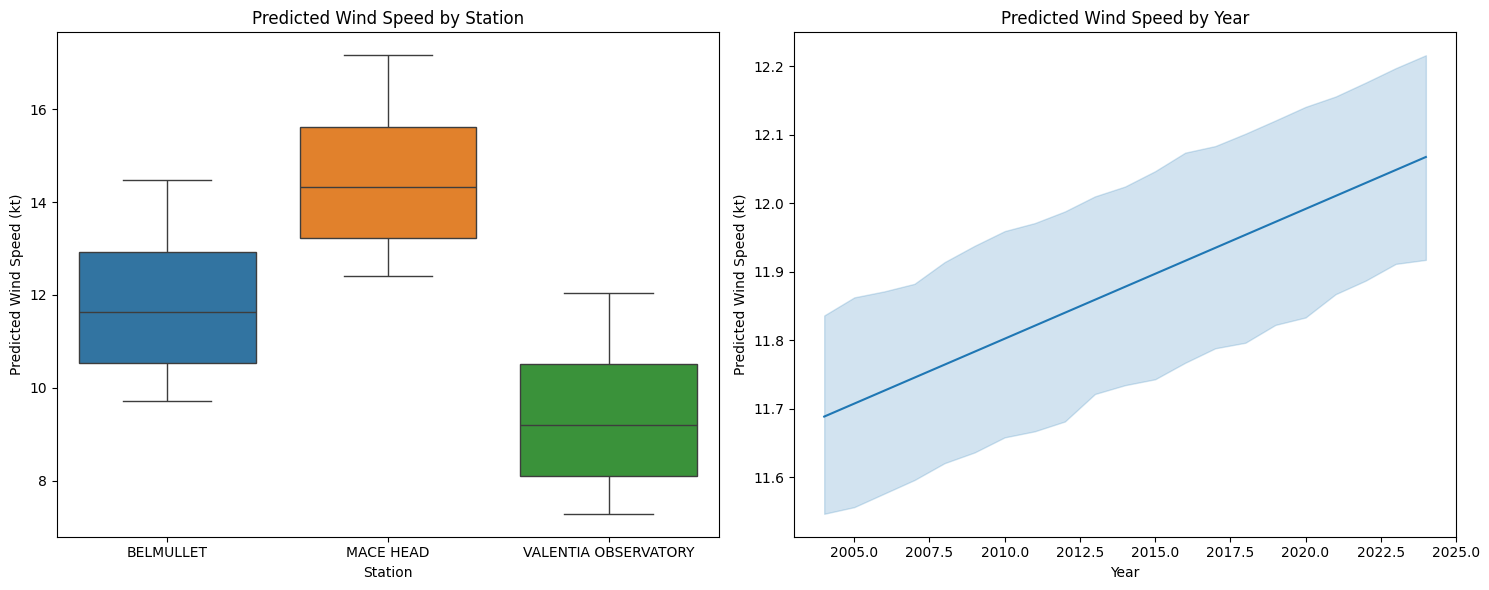

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Boxplot for y_pred by station name
sns.boxplot(ax=axes[0], x='name', y='y_pred',hue='name', data=new_data)
axes[0].set_title('Predicted Wind Speed by Station')
axes[0].set_xlabel('Station')
axes[0].set_ylabel('Predicted Wind Speed (kt)')

# Boxplot for y_pred by year
sns.lineplot(ax=axes[1], x='year', y='y_pred', data=new_data)
axes[1].set_title('Predicted Wind Speed by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Predicted Wind Speed (kt)')

plt.tight_layout()
plt.show()

In [50]:
# Extract the predicted wind speeds for each station
predicted_wind_speeds = new_data[['name', 'y_pred']]

# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=predicted_wind_speeds['y_pred'], groups=predicted_wind_speeds['name'], alpha=0.05)

# Print the results
print(tukey_result)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
  group1         group2        meandiff p-adj  lower   upper  reject
--------------------------------------------------------------------
BELMULLET            MACE HEAD   2.6978   0.0  2.6454  2.7502   True
BELMULLET VALENTIA OBSERVATORY  -2.4287   0.0 -2.4811 -2.3763   True
MACE HEAD VALENTIA OBSERVATORY  -5.1265   0.0 -5.1789 -5.0741   True
--------------------------------------------------------------------


Finally, we see that wind speeds tend to be higher in the beginning and end of the year, with the lowest wind speeds displayed over the summer. 

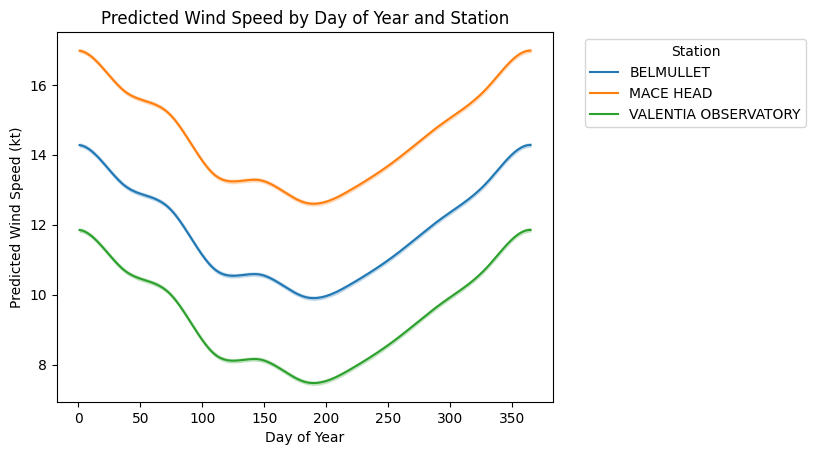

In [51]:
sns.lineplot(data=new_data, x='day_of_year', y='y_pred', hue='name')
plt.title('Predicted Wind Speed by Day of Year and Station')
plt.xlabel('Day of Year')
plt.ylabel('Predicted Wind Speed (kt)')
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Even though we have subtracted meaningful information from the fitted model, we have not assessed wether or not the model fits the data appropriately. To do so, we need to inspect the residuals from the model,d ifference between the observed values of the dependent variable and the values predicted by the model (https://rpubs.com/iabrady/residual-analysis). We can clearly see that the model is not appropriately capturing the wind speed ranges observed in the real data. The first plots shows how, in the wind speed data, speeds over 20 knots are quite often, but our model fails to predict wind speeds barely above 16 knots. The next plot shows the residuals increasing systematically  when plotted against fitted values. This indicates that the model assumption of homoscedasticity  is being violated which can lead to inefficient estimates of coefficients and unreliable standard errors, affecting hypothesis testing. Finally, the histogram of residuals and the QQ-plot clearly shows that the data is not normally distributed, with the tails of our data not being captured by the Normal distribution.

All these plots indicate major problems with the fitted model that would require attention before any conclusion is extracted. Firstly, I will have to investigate if another family distribution fits the data better. Considering that the data is strictly positive, but has 0 values, I believe some candidate might be the Weibull distribution or Zero Inflated models. Another option might be to see if any data transformation is needed (?log-transformed). I would then consider if hourly data is really required to answer the question we have in hand. Perhaps daily average data would reduce some of the noise and help fit the model. I will also investigate how we have formulated the model, and if there is any potential missing covariates. 

c:\Python311\Lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


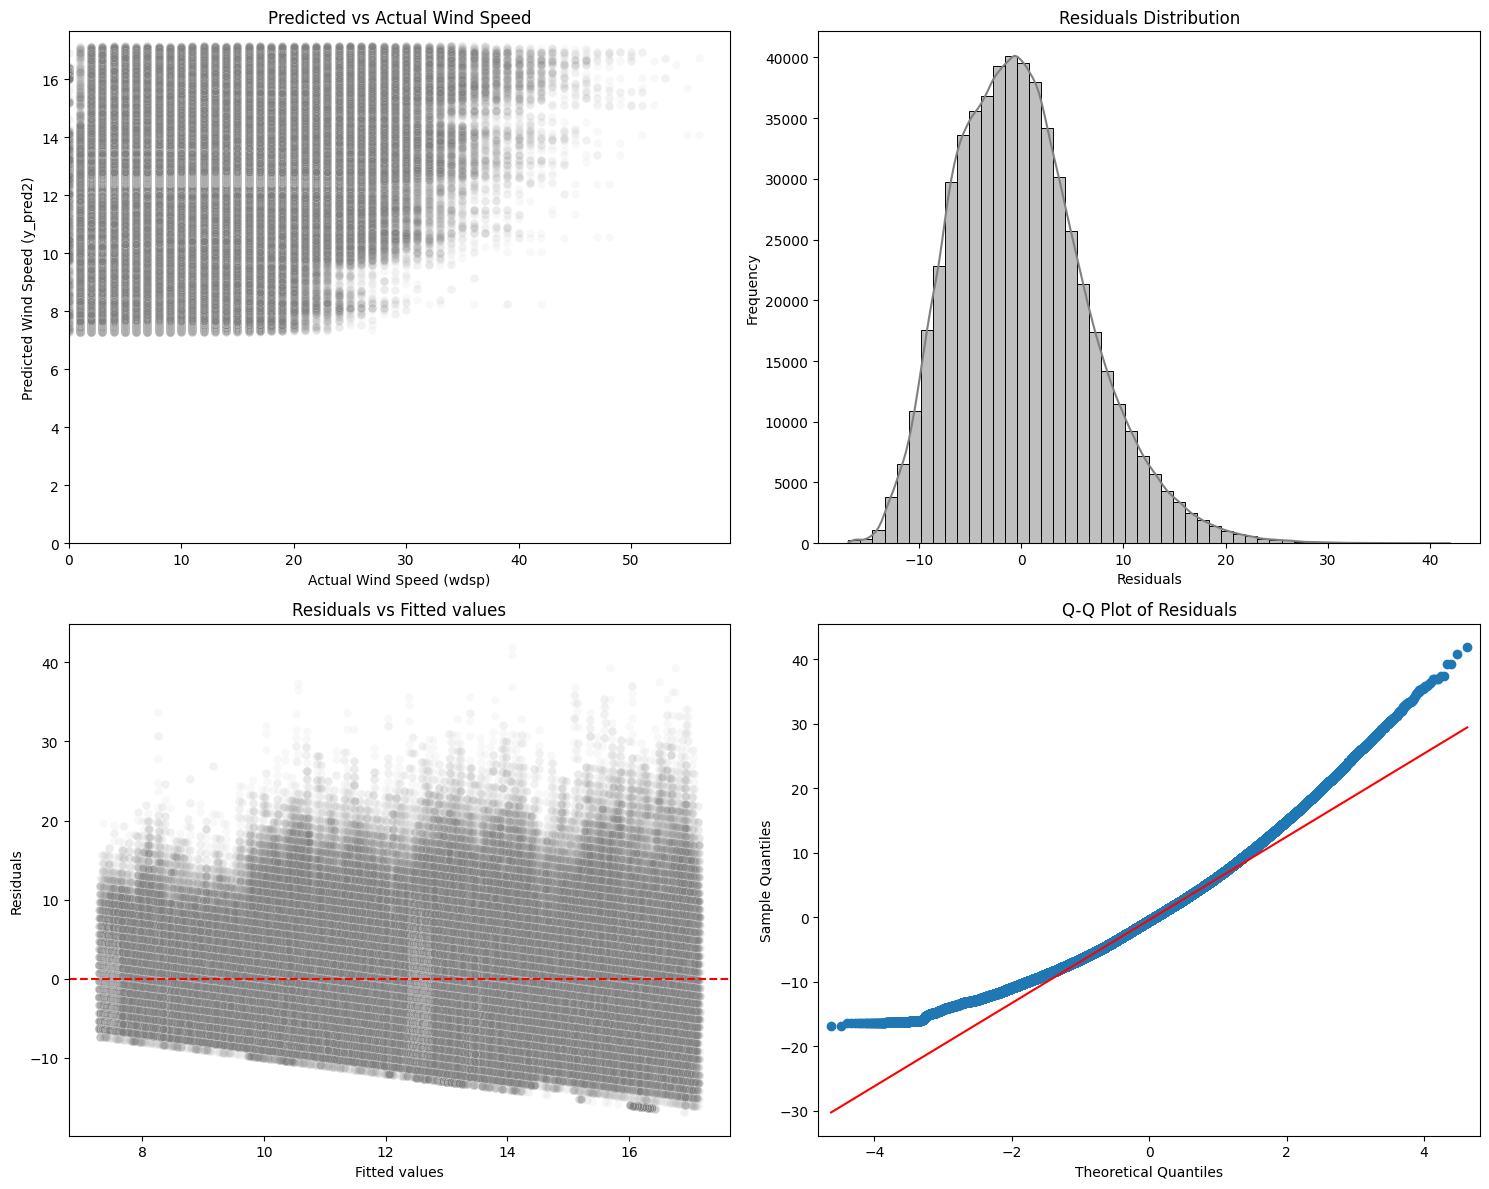

In [52]:
residuals=gam.deviance_residuals(X,datasub_gam['wdsp'])
y_pred2= gam.predict(X)
datasub_gam['residuals']=residuals
datasub_gam['y_pred2']=y_pred2

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot of predicted vs actual wind speed
sns.scatterplot(ax=axes[0, 0], x='wdsp', y='y_pred2', data=datasub_gam, alpha=0.05, color='grey')
axes[0, 0].set_title('Predicted vs Actual Wind Speed')
axes[0, 0].set_xlabel('Actual Wind Speed (wdsp)')
axes[0, 0].set_ylabel('Predicted Wind Speed (y_pred2)')
axes[0, 0].set_xlim(0, None)
axes[0, 0].set_ylim(0, None)

# Residuals vs Fitted values
sns.scatterplot(ax=axes[1, 0], x='y_pred2', y='residuals', data=datasub_gam, alpha=0.05, color='grey')
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Residuals vs Fitted values')
axes[1, 0].set_xlabel('Fitted values')
axes[1, 0].set_ylabel('Residuals')

sns.histplot(ax=axes[0, 1], x='residuals', data=datasub_gam, bins=50, kde=True, color='grey')
axes[0, 1].set_title('Residuals Distribution')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Q-Q plot of residuals
sm.qqplot(datasub_gam['residuals'], line='q', ax=axes[1, 1], color='grey')
axes[1, 1].set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

C:\Users\Owner\AppData\Local\Temp\ipykernel_13344\2641716693.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for station, group in data.groupby('name'):


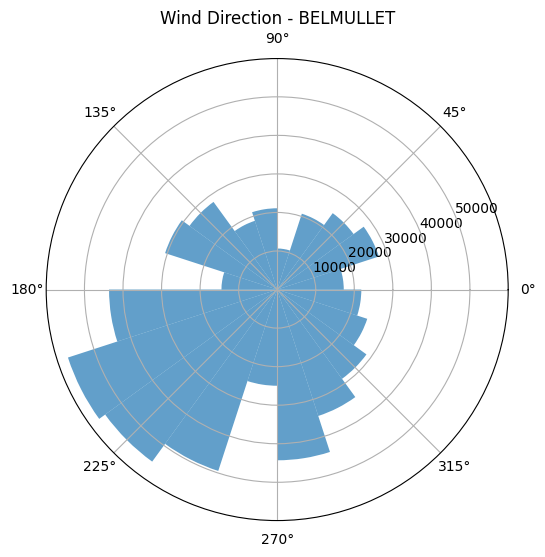

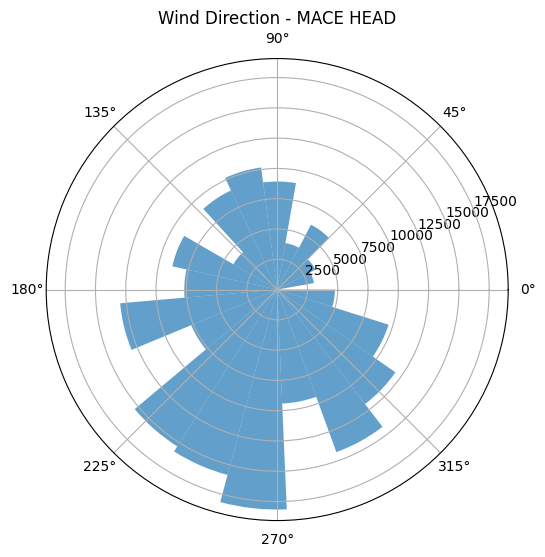

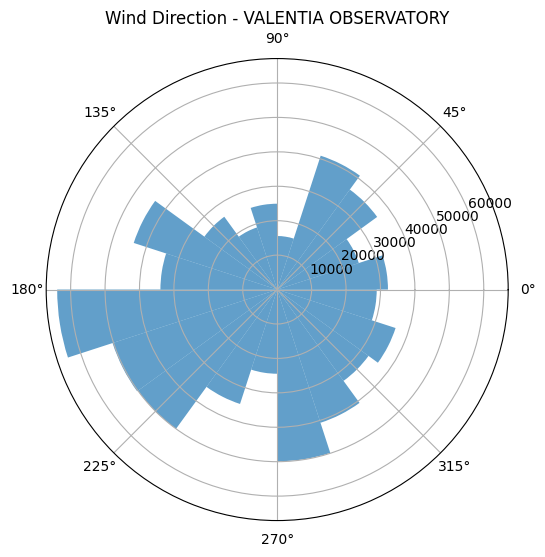

In [53]:
for station, group in data.groupby('name'):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    theta = np.deg2rad(group['wddir'])
    ax.hist(theta, bins=20, alpha=0.7)
    plt.title(f'Wind Direction - {station}')
    plt.show()